In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from datasets import load_dataset, concatenate_datasets
import json
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


/home/ubuntu/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        # wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        if attn_mask is not None:
            wei = F.softmax(wei*attn_mask, dim=-1) # (B, T, T)
        else:
            wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask):
        out = torch.cat([h(x, attn_mask) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, attn_mask):
        x = x + self.sa(self.ln1(x), attn_mask)
        x = x + self.ffwd(self.ln2(x))
        return x

class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_x = nn.Embedding(block_size, n_embd//2)
        self.position_embedding_y = nn.Embedding(block_size, n_embd//2)
        # self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.blocks = nn.ModuleList([Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, 1)
        self.lm_head2 = nn.Linear(n_embd, 2)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.001)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.001)

    def forward(self, idx, mask=False):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_x, pos_y = idx_to_coord_train(d)
        pos_x_emb = self.position_embedding_x(pos_x.to(device=device)) # (T,C/2)
        pos_y_emb = self.position_embedding_y(pos_y.to(device=device)) # (T,C/2)
        pos_emb = torch.cat((pos_x_emb,pos_y_emb), dim= 1) # (T,C)
        x_emb = tok_emb + pos_emb # (B,T,C)
        # x = self.blocks(x, attn_mask) # (B,T,C)
        if mask is False:
            loss = None
            x = x_emb
            for block in self.blocks:
                x = block(x)
            x = self.ln_f(x) # (B,T,C)
            x = torch.sum(x, dim=1) # (B,C)
            logits = self.lm_head2(x) # (B,1)
            y = F.sigmoid(logits)

        else:
            # logits = logits.view(B*T, C)
            # targets = targets.view(B*T)
            # loss = F.cross_entropy(logits, targets)
            loss = 0
            for idx_mask in range(T):
                attn_mask = torch.ones(T,T).to(idx.device)
                attn_mask[idx_mask,:] = 0
                attn_mask[:,idx_mask] = 0
                x = x_emb
                for block in self.blocks:
                    x = block(x, attn_mask)
                x = self.ln_f(x) # (B,T,C)
                x = torch.sum(x, dim=1) # (B,C)
                logits = self.lm_head(x) # (B,1)
                y = F.sigmoid(logits).squeeze()
                # print(y.shape,targets.shape)
                eps = 1e-9
                # print(val.shape)
                targets = idx[:,idx_mask]
                loss += -(targets*torch.log(y+eps)+(1-targets)*torch.log(1-y+eps)).mean(dim=0)
            loss /= T
        return y, loss


def idx_to_coord_train(d):
    sz_list = {}
    c_sz = (d**2-1)-1
    for row in range(d):
        for col in range(d):
            x, y = col-(d-1)/2, row-(d-1)/2
            if row %2 ==1 and col % 2 == 0:
                x_sz, y_sz = x+(d-1)/2+1, y+ (d-1)/2+1
                sz_list[f"{c_sz}"] = (x_sz, y_sz)
                c_sz -= 1
            if row %2 ==0 and col % 2 == 0 and row < d-1:
                x_sz, y_sz = x +(d-1)/2, y +(d-1)/2+1
                sz_list[f"{c_sz}"] = (x_sz, y_sz)
                c_sz -= 1

    c_q = 0
    sx_list = {}
    c_sx = 0# (d**2-1)-1
    for col in range(d):
        for row in range(d):
            x, y = col-(d-1)/2, (d-1)/2-row
            if row %2 ==0 and col % 2 == 1:
                x_s, y_s = x+(d-1)/2+1, y+(d-1)/2
                sx_list[f"{c_sx}"] = (x_s, y_s)
                c_sx += 1
            if row %2 ==0 and col % 2 == 0 and col < d-1:
                x_s, y_s = x+(d-1)/2+1, y+(d-1)/2+1
                sx_list[f"{c_sx}"] = (x_s, y_s)
                c_sx += 1

    pos_x = torch.zeros(d**2-1, dtype= torch.int32)
    pos_y = torch.zeros(d**2-1, dtype= torch.int32)
    for idx in range((d**2-1)//2):
        pos_x[idx]= sx_list[f"{idx}"][0]
        pos_y[idx]= sx_list[f"{idx}"][1]

    for idx in range((d**2-1)//2,d**2-1):
        pos_x[idx]= sz_list[f"{idx}"][0]
        pos_y[idx]= sz_list[f"{idx}"][1]

    return pos_x, pos_y


In [3]:
# hyperparameters
batch_size = 1000 # how many independent sequences will we process in parallel?
block_size = 15 # what is the maximum context length for predictions?
max_iters = 5000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 256 #384
n_head = 4
n_layer = 4
dropout = 0.2
vocab_size = 2
# ------------

d = 5 # must be an odd number
model = Encoder()
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()), 'parameters')

p_err_train = 0.1
p_err_val = 0.15
dataset = load_dataset("json", data_files={
        'train' : f"datasets/train_d_{d}_p_{p_err_train:.2f}.json",
        'val' : f"datasets/val_d_{d}_p_{p_err_val:.2f}.json"
    })

def collate_fn(examples):
    input = [example['input'] for example in examples]
    target = [example['target'] for example in examples]
    return {'input': input, 'target': target}

data_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset["val"], batch_size=batch_size, collate_fn=collate_fn)


3161603 parameters


In [32]:
d = 7

p_err = 0.15
dataset = load_dataset("json", data_files={
        'test' : f"datasets/test_d_{d}_p_{p_err:.2f}.json"
    })
ex_indx = torch.randint(1000,(1,))
print(ex_indx)
examples = dataset["test"]["input"][ex_indx:ex_indx+2]
x = torch.tensor(examples).to(device, dtype= torch.int32)

tensor([485])


In [33]:
B, T = x.shape
# attn_mask = torch.ones(T,T).to(device)
# idx_mask = 10
# attn_mask[idx_mask,:] = 0
# attn_mask[:,idx_mask] = 0
with torch.no_grad():
    out = model(x, mask=True)#x[:,idx_mask])#, attn_mask)
print(out)

(tensor([1.0000e+00, 6.7572e-11], device='cuda:0'), tensor(0., device='cuda:0'))


In [10]:
print(out[1])
# plt.plot(out[0].cpu().detach().numpy(),".")

tensor(1.0747e-07, device='cuda:0')


In [4]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    # for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    i = 0
    # data_loader_loss = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for batch in data_loader:
        if i >= eval_iters:
            break
        # X = torch.tensor(batch['input']).to(device)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        # Y = torch.tensor(batch['target']).to(device)
        err_probs, loss = model(X,mask=True)

        losses[i] = loss.item()
        i += 1
    out["train"] = losses.mean()

    i = 0
    out["val"] = 0
    for batch in data_loader_val:
        # X = torch.tensor(batch['input']).to(device)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        # Y = torch.tensor(batch['target']).to(device)
        err_probs, loss = model(X,mask=True)

        out["val"] += loss.item()
        i += 1
    out["val"] /= i
    
    model.train()
    return out

def estimate_accuracy():
    model.eval()
    i = 0
    acc = 0
    for batch in data_loader_val:
        # X = torch.tensor(batch['input']).to(device)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        Y = torch.tensor(batch['target']).to(device)
        err_probs, _ = model(X)
        pred = (err_probs > 0.5).to(Y)
        # print(err_probs.shape, Y.shape)
        acc += torch.sum(pred == Y, dim=(0,1))/Y.shape[0]/2
        i += 1
    acc /= i
    
    model.train()
    return acc.item()


In [5]:
learning_rate = 3e-4
# # create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

eval_interval = 100
eval_iters =  10
num_epochs = 1000

loss_train = []
loss_val = []
acc_val = []
for epoch in range(num_epochs):
    iter = 0
    # if epoch % 10 == 0:
    # # if iter % eval_interval == 0:
    # losses = estimate_loss()
    # acc = estimate_accuracy()
    # print(f"epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, val acc {acc:.4f}")
    # loss_train.append(losses['train'])
    # loss_val.append(losses['val'])
    # acc_val.append(acc)

    # data_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for i_b, batch in enumerate(data_loader):
        # if i_b>= eval_iters:
        #     break
        # every once in a while evaluate the loss on train and val sets
        # if epoch % 10 == 0:
        if iter % eval_interval == 0:
            losses = estimate_loss()
            print(f"epoch, step {epoch, iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            # acc = estimate_accuracy()
            # print(f"epoch, step {epoch, iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, val acc {acc:.4f}")
            loss_train.append(losses['train'])
            loss_val.append(losses['val'])
            # acc_val.append(acc)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        # Y = torch.tensor(batch['target']).to(device)
        err_probs, loss = model(X, mask=True)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        iter += 1



epoch, step (0, 0): train loss 0.7773, val loss 0.7550
epoch, step (0, 100): train loss 0.4944, val loss 0.5894
epoch, step (0, 200): train loss 0.4951, val loss 0.5916
epoch, step (0, 300): train loss 0.4954, val loss 0.5926
epoch, step (0, 400): train loss 0.4931, val loss 0.5707
epoch, step (0, 500): train loss 0.4918, val loss 0.5740
epoch, step (0, 600): train loss 0.4728, val loss 0.5629
epoch, step (0, 700): train loss 0.0000, val loss 0.0000
epoch, step (0, 800): train loss 0.0000, val loss 0.0000


KeyboardInterrupt: 

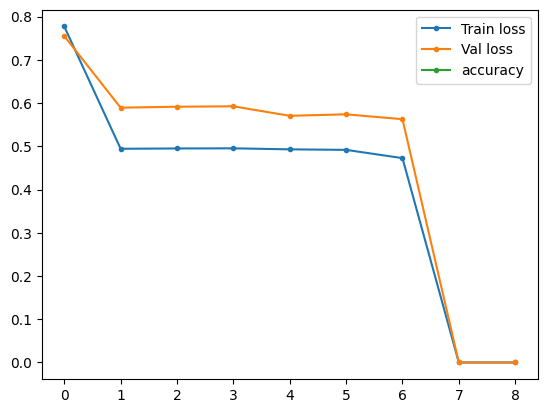

In [6]:

plt.plot(loss_train,".-",label="Train loss")
plt.plot(loss_val,".-",label="Val loss")
plt.plot(acc_val,".-",label="accuracy")
plt.legend()


In [18]:
model.eval()
acc = 0
i = 0
for batch in data_loader:
    if i >= eval_iters:
        break
    X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
    Y = torch.tensor(batch['target']).to(device)
    err_probs, _ = model(X)
    pred = (err_probs > 0.5).to(Y)
    # print(err_probs.shape, Y.shape)
    acc += torch.sum(pred == Y, dim=(0,1))/Y.shape[0]/2
    i += 1
acc /= i

model.train()
print(acc.item())

0.9564499855041504


In [28]:
PATH = f"models/enc_masked_hl_{n_head}_{n_layer}_lr_{learning_rate:.3f}.pt"
# saving the state
# model.to(device)
# torch.save(model.state_dict(), PATH)
checkpoint = {
"epoch": 2,
"model_state": model.state_dict(),
"optim_state": optimizer.state_dict()
}
# print(optimizer.state_dict())
# FILE = "checkpoint.pth"
torch.save(checkpoint, PATH)

In [3]:
# hyperparameters
batch_size = 100 # how many independent sequences will we process in parallel?
block_size = 15 # what is the maximum context length for predictions?
max_iters = 5000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 256 #384
n_head = 4
n_layer = 4
dropout = 0.2
vocab_size = 2
learning_rate = 3e-4
# ------------
FILE = f"models/enc_masked_hl_{n_head}_{n_layer}_lr_{learning_rate:.3f}.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Encoder()

optimizer = torch.optim.AdamW(model.parameters(), lr=0)
# optimizer = torch.optim.SGD(model.parameters(), lr=0)
checkpoint = torch.load(FILE)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])
epoch = checkpoint['epoch']

# model.load_state_dict(torch.load(PATH))
model.to(device)

Encoder(
  (token_embedding_table): Embedding(2, 256)
  (position_embedding_x): Embedding(15, 128)
  (position_embedding_y): Embedding(15, 128)
  (blocks): ModuleList(
    (0-3): 4 x Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=256, out_features=64, bias=False)
            (query): Linear(in_features=256, out_features=64, bias=False)
            (value): Linear(in_features=256, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((2

In [19]:
# d = 5 # must be an odd number
# n_hidden = [500, 512, 512]
# learning_rate = [1e-2,1e-2,1e-3]
# device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 1000
p_err_list = torch.arange(0.01,0.31,0.01)
d_list = [5,7,9]
acc = torch.zeros((p_err_list.shape[0],len(d_list)))
for i_d,d in enumerate(d_list):
    # model = load_model(d,n_hidden[i_d],learning_rate)
    # FILE = f"models/d_{d}_nh_{n_hidden[i_d]}_lr_{learning_rate[i_d]:.3f}.pt"

    # model = MLP(d, n_hidden[i_d])

    # optimizer = torch.optim.AdamW(model.parameters(), lr=0)
    # checkpoint = torch.load(FILE)
    # model.load_state_dict(checkpoint['model_state'])
    # optimizer.load_state_dict(checkpoint['optim_state'])
    # epoch = checkpoint['epoch']

    # # model.load_state_dict(torch.load(PATH))
    # model.to(device)
    model.eval()
    for i_p, p_err in enumerate(p_err_list):
        dataset = load_dataset("json", data_files={
                'test' : f"datasets/test_d_{d}_p_{p_err:.2f}.json"
            })
        data_loader_test = DataLoader(dataset["test"], batch_size=batch_size, collate_fn=collate_fn)

        with torch.no_grad():
            for i_b, batch in enumerate(data_loader_test):
                X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
                Y = torch.tensor(batch['target']).to(device)
                err_probs, _ = model(X)
                pred = (err_probs > 0.5).to(Y)
                acc[i_p,i_d] += torch.sum(pred == Y, dim=(0,1)).item()/Y.shape[0]/2
            # print(i_b)
            acc[i_p,i_d] /= (i_b+1)

# model.train()
# del model


Generating test split: 1000 examples [00:00, 191836.08 examples/s]
Generating test split: 1000 examples [00:00, 207751.94 examples/s]
Generating test split: 1000 examples [00:00, 212833.21 examples/s]
Generating test split: 1000 examples [00:00, 187555.52 examples/s]
Generating test split: 1000 examples [00:00, 202711.52 examples/s]
Generating test split: 1000 examples [00:00, 209317.50 examples/s]
Generating test split: 1000 examples [00:00, 199548.22 examples/s]
Generating test split: 1000 examples [00:00, 203202.56 examples/s]
Generating test split: 1000 examples [00:00, 209820.11 examples/s]
Generating test split: 1000 examples [00:00, 196004.67 examples/s]
Generating test split: 1000 examples [00:00, 196261.48 examples/s]
Generating test split: 1000 examples [00:00, 207515.54 examples/s]
Generating test split: 1000 examples [00:00, 188516.52 examples/s]
Generating test split: 1000 examples [00:00, 204360.94 examples/s]
Generating test split: 1000 examples [00:00, 190997.45 example

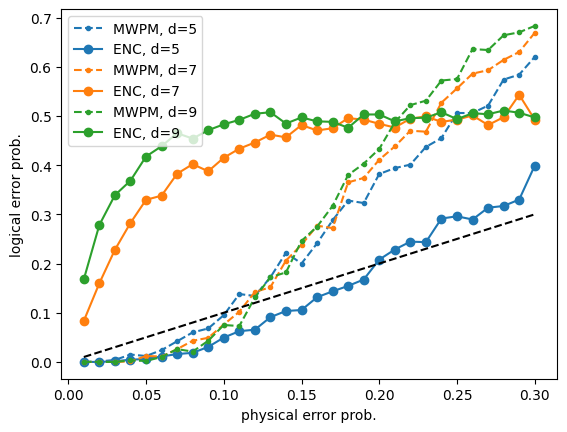

In [20]:
def mwpm_file_reader(d):
    fname = f"results/mwpm_sweep_d_{d}.json"
    f = open(fname)
    data = json.load(f)
    f.close()
    return data['p_err'], data['logical_err']

for i_d, d in enumerate(d_list):
    p_err_list,logical_err_mwpm = mwpm_file_reader(d)
    plt.plot(p_err_list,logical_err_mwpm,".--", color= f"C{i_d}",label=f"MWPM, d={d}")
    plt.plot(p_err_list,1-acc[:,i_d],"o-", color= f"C{i_d}",label=f"ENC, d={d}")

plt.plot(p_err_list,p_err_list,"k--")
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()
